---
title: Dihedrals and Ramachandran plots
---

This notebook requires biopython and PeptideBuilder, which can be installed through pip with

```
pip install biopython PeptideBuilder
```

In [1]:
import Bio
import PeptideBuilder as PB
import itertools
import numpy as np

In [90]:
VDW_RADII = {
    "H" : 1.20,
    "C" : 1.70,
    "N" : 1.55,
    "O" : 1.52,
    "P" : 1.80,
    "S" : 1.80,
}

# return 1 if there are overlaps, 0 otherwise
def energy(structure):
    atoms = structure.get_atoms()
    # N^2 computation, not efficient but good enough for small molecules
    for p, q in itertools.combinations(atoms, 2):
        if abs(p.parent.id[1] - q.parent.id[1]) != 1: # we check only consecutive residues
            continue
        elif p.name == "C" and q.name == "N" or p.name == "N" and q.name == "C":
            continue

        p_elem = p.name[0]
        q_elem = q.name[0]
        radius = (VDW_RADII[p_elem] + VDW_RADII[q_elem]) * 0.72 # heuristic rescaling factor
        if np.linalg.norm(p - q) < radius:
            print(q_elem, p_elem)
            return 1
    return 0

In [91]:
geo_ends = PB.Geometry.geometry("G")
structure = PB.initialize_res(geo_ends)
PB.add_residue(structure, "G", -5, 0)
PB.add_residue(structure, geo_ends)

print(energy(structure))

for a in structure.get_atoms():
    print(a.get_full_id())

C C
1
('X', 0, 'A', (' ', 1, ' '), ('N', ' '))
('X', 0, 'A', (' ', 1, ' '), ('CA', ' '))
('X', 0, 'A', (' ', 1, ' '), ('C', ' '))
('X', 0, 'A', (' ', 1, ' '), ('O', ' '))
('X', 0, 'A', (' ', 2, ' '), ('N', ' '))
('X', 0, 'A', (' ', 2, ' '), ('CA', ' '))
('X', 0, 'A', (' ', 2, ' '), ('C', ' '))
('X', 0, 'A', (' ', 2, ' '), ('O', ' '))
('X', 0, 'A', (' ', 3, ' '), ('N', ' '))
('X', 0, 'A', (' ', 3, ' '), ('CA', ' '))
('X', 0, 'A', (' ', 3, ' '), ('C', ' '))
('X', 0, 'A', (' ', 3, ' '), ('O', ' '))


In [92]:
import matplotlib.pyplot as plt
from matplotlib import colors

# create a peptide consisting of 3 glycines, adapter from PeptideBuilder's example
phis = np.array(list(range(-175, 180, 100)))
psis = np.array(list(range(-175, 180, 100)))
forbidden_psi = []
forbidden_phi = []
energies = np.zeros((phis.shape[0], psis.shape[0]))
for i, phi in enumerate(phis):
    for j, psi in enumerate(psis):
        geo_ends = PB.Geometry.geometry("G")
        structure = PB.initialize_res(geo_ends)
        PB.add_residue(structure, "G", phi, psi)
        PB.add_residue(structure, geo_ends)
        
        E = energy(structure)
        energies[j, i] = E
        if E == 1:
            forbidden_phi.append(phi)
            forbidden_psi.append(psi)
            
np.savetxt("combs.dat", energies)

C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C
C C


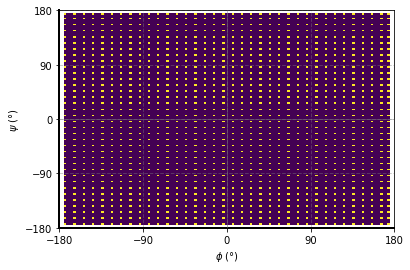

In [89]:
def format_axis(axis):
    zero_lines_kwargs = {
        "colors" : ["Grey"], 
        "alpha" : 0.4, 
        "zorder" : 3, 
        "linewidths" : [1]
        }

    axis.grid(alpha=0.4, linestyle="--", linewidth=1, color="Grey", zorder=3)
    axis.hlines(0, -180, 180, **zero_lines_kwargs)
    axis.vlines(0, -180, 180, **zero_lines_kwargs)
    
    axis.set_xlim((-180, 180))
    axis.set_ylim((-180, 180))
    axis.set_xlabel(u"$\phi$ (\u00B0)")	# phi
    axis.set_ylabel(u"$\psi$ (\u00B0)")	# psi

    axis.set_xticks([-180, -90, 0, 90, 180])
    axis.set_yticks([-180, -90, 0, 90, 180])

    ax_linewidth = 2
    axis.spines["left"].set_linewidth(ax_linewidth)
    axis.spines["bottom"].set_linewidth(ax_linewidth)
    
fig, ax = plt.subplots()
kwargs = {
    "bins" : 140, 
    "norm" : colors.PowerNorm(0.1),
    "alpha" : 1}
ax.hist2d(forbidden_phi, forbidden_psi, **kwargs)
format_axis(ax)

In [93]:
out = Bio.PDB.PDBIO()
out.set_structure(structure)
out.save("example.pdb")